In [3]:
import gymnasium
import flappy_bird_gymnasium
import pickle
import gc
import numpy as np
import pygame
import itertools
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.distributions import Categorical
from collections import deque
from enum import IntEnum
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
from flappy_bird_gymnasium.envs.flappy_bird_env import FlappyBirdEnv
from flappy_bird_gymnasium.envs.flappy_bird_env import Actions
from flappy_bird_gymnasium.envs import utils
from flappy_bird_gymnasium.envs.lidar import LIDAR
from flappy_bird_gymnasium.envs.constants import (
    BACKGROUND_WIDTH,
    BASE_WIDTH,
    FILL_BACKGROUND_COLOR,
    LIDAR_MAX_DISTANCE,
    PIPE_HEIGHT,
    PIPE_VEL_X,
    PIPE_WIDTH,
    PLAYER_ACC_Y,
    PLAYER_FLAP_ACC,
    PLAYER_HEIGHT,
    PLAYER_MAX_VEL_Y,
    PLAYER_PRIVATE_ZONE,
    PLAYER_ROT_THR,
    PLAYER_VEL_ROT,
    PLAYER_WIDTH,
)
from typing import Dict, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties



def new_render(self):
    """Renders the next frame."""
    if self.render_mode == "rgb_array":
        self._draw_surface(show_score=False, show_rays=False)
        # Flip the image to retrieve a correct aspect
        return np.transpose(pygame.surfarray.array3d(self._surface), axes=(1, 0, 2))
    else:
        self._draw_surface(show_score=True, show_rays=False)
        if self._display is None:
            self._make_display()

        self._update_display()
        self._fps_clock.tick(self.metadata["render_fps"])

def new_step(
    self,
    action: Union[Actions, int],
) -> Tuple[np.ndarray, float, bool, Dict]:
    """Given an action, updates the game state.

    Args:
        action (Union[FlappyBirdLogic.Actions, int]): The action taken by
            the agent. Zero (0) means "do nothing" and one (1) means "flap".

    Returns:
        A tuple containing, respectively:

            * an observation (horizontal distance to the next pipe
                difference between the player's y position and the next hole's
                y position)
            * a reward (alive = +0.1, pipe = +1.0, dead = -1.0)
            * a status report (`True` if the game is over and `False`
                otherwise)
            * an info dictionary
    """
    """Given an action taken by the player, updates the game's state.

    Args:
        action (Union[FlappyBirdLogic.Actions, int]): The action taken by
            the player.

    Returns:
        `True` if the player is alive and `False` otherwise.
    """
    terminal = False
    reward = None

    self._sound_cache = None
    if action == Actions.FLAP:
        if self._player_y > -2 * PLAYER_HEIGHT:
            self._player_vel_y = PLAYER_FLAP_ACC
            self._player_flapped = True
            self._sound_cache = "wing"

    # check for score
    player_mid_pos = self._player_x + PLAYER_WIDTH / 2
    for pipe in self._upper_pipes:
        pipe_mid_pos = pipe["x"] + PIPE_WIDTH / 2
        if pipe_mid_pos <= player_mid_pos < pipe_mid_pos + 4:
            self._score += 1
            reward = 1.0  # reward for passed pipe
            self._sound_cache = "point"

    # player_index base_x change
    if (self._loop_iter + 1) % 3 == 0:
        self._player_idx = next(self._player_idx_gen)

    self._loop_iter = (self._loop_iter + 1) % 30
    self._ground["x"] = -((-self._ground["x"] + 100) % self._base_shift)

    # rotate the player
    if self._player_rot > -90:
        self._player_rot -= PLAYER_VEL_ROT

    # player's movement
    if self._player_vel_y < PLAYER_MAX_VEL_Y and not self._player_flapped:
        self._player_vel_y += PLAYER_ACC_Y

    if self._player_flapped:
        self._player_flapped = False

        # more rotation to cover the threshold
        # (calculated in visible rotation)
        self._player_rot = 45

    self._player_y += min(
        self._player_vel_y, self._ground["y"] - self._player_y - PLAYER_HEIGHT
    )

    # move pipes to left
    for up_pipe, low_pipe in zip(self._upper_pipes, self._lower_pipes):
        up_pipe["x"] += PIPE_VEL_X
        low_pipe["x"] += PIPE_VEL_X

        # it is out of the screen
        if up_pipe["x"] < -PIPE_WIDTH:
            new_up_pipe, new_low_pipe = self._get_random_pipe()
            up_pipe["x"] = new_up_pipe["x"]
            up_pipe["y"] = new_up_pipe["y"]
            low_pipe["x"] = new_low_pipe["x"]
            low_pipe["y"] = new_low_pipe["y"]

    if self.render_mode == "human":
        self.render()

    obs, reward_private_zone = self._get_observation()
    if reward is None:
        if reward_private_zone is not None:
            reward = float(reward_private_zone)
        else:
            reward = 0.1  # reward for staying alive

    # check
    if self._debug and self._use_lidar:
        # sort pipes by the distance between pipe and agent
        up_pipe = sorted(
            self._upper_pipes,
            key=lambda x: np.sqrt(
                (self._player_x - x["x"]) ** 2
                + (self._player_y - (x["y"] + PIPE_HEIGHT)) ** 2
            ),
        )[0]
        # find ray closest to the obstacle
        min_index = np.argmin(obs)
        min_value = obs[min_index] * LIDAR_MAX_DISTANCE
        # mean approach to the obstacle
        if "pipe_mean_value" in self._statistics:
            self._statistics["pipe_mean_value"] = self._statistics[
                "pipe_mean_value"
            ] * 0.99 + min_value * (1 - 0.99)
        else:
            self._statistics["pipe_mean_value"] = min_value

        # Nearest to the pipe
        if "pipe_min_value" in self._statistics:
            if min_value < self._statistics["pipe_min_value"]:
                self._statistics["pipe_min_value"] = min_value
                self._statistics["pipe_min_index"] = min_index
        else:
            self._statistics["pipe_min_value"] = min_value
            self._statistics["pipe_min_index"] = min_index

        # Nearest to the ground
        diff = np.abs(self._player_y - self._ground["y"])
        if "ground_min_value" in self._statistics:
            if diff < self._statistics["ground_min_value"]:
                self._statistics["ground_min_value"] = diff
        else:
            self._statistics["ground_min_value"] = diff

    # agent touch the top of the screen as punishment
    if self._player_y < 0:
        reward = -0.5

    # check for crash
    if self._check_crash():
        self._sound_cache = "hit"
        reward = -1.0  # reward for dying
        terminal = True
        self._player_vel_y = 0
        if self._debug and self._use_lidar:
            if ((self._player_x + PLAYER_WIDTH) - up_pipe["x"]) > (0 + 5) and (
                self._player_x - up_pipe["x"]
            ) < PIPE_WIDTH:
                print("BETWEEN PIPES")
            elif ((self._player_x + PLAYER_WIDTH) - up_pipe["x"]) < (0 + 5):
                print("IN FRONT OF")
            print(
                f"obs: [{self._statistics['pipe_min_index']},"
                f"{self._statistics['pipe_min_value']},"
                f"{self._statistics['pipe_mean_value']}],"
                f"Ground: {self._statistics['ground_min_value']}"
            )

    info = {"score": self._score}

    return (
        obs,
        np.float32(reward),
        terminal,
        (self._score_limit is not None) and (self._score >= self._score_limit),
        info,
    )


FlappyBirdEnv.render = new_render
FlappyBirdEnv.step = new_step

In [6]:


def smooth_data(data, window_size=10):
    """Apply a simple moving average smoothing to the data."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_rewards_with_opacity(rewards_dict, title, xlabel, ylabel, img_name):

    avg_rewards = {key: np.mean(rewards) for key, rewards in rewards_dict.items()} ##coefficients of variation
    top3_keys = sorted(avg_rewards, key=avg_rewards.get, reverse=True)[:3]
    
    

    fig, ax = plt.subplots(figsize=(15, 6))
    num_combinations = len(rewards_dict)
    cmap = cm.get_cmap("cool", num_combinations)
    
    # Loop through each hyperparameter combination and plot with a color from the colormap
    for idx, (key, rewards) in enumerate(rewards_dict.items()):

        smoothed_rewards = smooth_data(rewards, window_size=100)
        color = cmap(idx)  # Get the color for this hyperparameter combination
        # Adjust opacity for non-top3 combinations
        alpha = 1.0 if key in top3_keys else 0.05
        ax.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards, label=key, color=color, alpha=alpha,linewidth=0.7)
    
    # Set title with bold font
    ax.set_title(title, fontweight='bold',fontsize=18)
    ax.set_xlabel(xlabel,fontweight='bold')
    ax.set_ylabel(ylabel,fontweight='bold')
    
    
    # Place the legend in the bottom-right corner, remove title, and make it smaller
    ax.legend(loc='center left', 
              bbox_to_anchor=(1.05, 0.5),  # Position the legend box outside to the right
              borderaxespad=0., 
              fancybox=True, 
              fontsize='small', 
              markerscale=0.5, 
            )  # Make the title bold
    fig.savefig(f'../img/{img_name}.png',dpi=600) 
    plt.tight_layout()  # Ensures the legend does not get clipped
    plt.show()

In [16]:
################
######EAC#######
################


class ActorCriticNet(nn.Module):
    def __init__(self, input_dim, action_space):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(128, action_space)
        )
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        shared = self.shared(x)
        return F.softmax(self.actor(shared), dim=-1), self.critic(shared)

class EAC_agent:
    def __init__(self, env, config):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        # Parameters
        self.actor_lr = config.get('actor_lr', 0.001)
        self.critic_lr = config.get('critic_lr', 0.005)
        self.gamma = config.get('gamma', 0.99)
        self.gae_lambda = config.get('gae_lambda', 0.95)
        self.entropy_coef = config.get('entropy_coef', 0.01)
        self.value_loss_coef = config.get('value_loss_coef', 0.5)
        self.max_grad_norm = config.get('max_grad_norm', 0.5)
        self.episodes = config.get('episodes', 5000)
        
        self.network = ActorCriticNet(self.state_dim, self.action_space).to(self.device)
        self.actor_optimizer = optim.Adam(self.network.parameters(), lr=self.actor_lr)
        self.critic_optimizer = optim.Adam(self.network.parameters(), lr=self.critic_lr)
        
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.masks = []



    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            probs, value = self.network(state)
            dist = Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
        
        return action.item(), log_prob.item(), value.item()

    def compute_gae(self):
        returns = []
        gae = 0
        for step in reversed(range(len(self.rewards))):
            if step == len(self.rewards) - 1:
                next_value = 0
            else:
                next_value = self.values[step + 1]
                
            delta = self.rewards[step] + self.gamma * next_value * self.masks[step] - self.values[step]
            gae = delta + self.gamma * self.gae_lambda * self.masks[step] * gae
            returns.insert(0, gae + self.values[step])
            
        return torch.FloatTensor(returns).to(self.device)

    def train_step(self):
        returns = self.compute_gae()
        
        values = torch.FloatTensor(self.values).to(self.device)
        log_probs = torch.FloatTensor(self.log_probs).to(self.device)
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        states = torch.FloatTensor(self.states).to(self.device)
        actions = torch.LongTensor(self.actions).to(self.device)
        
        # Forward pass
        new_probs, new_values = self.network(states)
        dist = Categorical(new_probs)
        new_log_probs = dist.log_prob(actions)
        entropy = dist.entropy().mean()
        
        # Actor loss
        ratio = torch.exp(new_log_probs - log_probs)
        surr1 = ratio * advantages
        actor_loss = -(surr1.mean() + self.entropy_coef * entropy)
        
        # Critic loss
        critic_loss = self.value_loss_coef * F.mse_loss(new_values.squeeze(-1), returns)
        
        # Total loss
        total_loss = actor_loss + critic_loss
        
        # Optimize
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), self.max_grad_norm)
        self.actor_optimizer.step()
        self.critic_optimizer.step()
        
        # Clear memory
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.masks.clear()
        self.states.clear()
        self.actions.clear()

    def train(self):
        rewards_history = []
        
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            
            self.states = []
            self.actions = []
            
            while not done:
                action, log_prob, value = self.select_action(state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                
                self.states.append(state)
                self.actions.append(action)
                self.rewards.append(reward)
                self.log_probs.append(log_prob)
                self.values.append(value)
                self.masks.append(1 - done)
                
                state = next_state
                total_reward += reward
                
                if truncated:
                    break
            
            self.train_step()
            rewards_history.append(total_reward)
            
            if episode % 100 == 0:
                avg_reward = np.mean(rewards_history[-100:])
                print(f"Episode {episode}, Reward: {total_reward:.2f}, Avg: {avg_reward:.2f}")
        
        return rewards_history

    def test(self, num_episodes=10,render="human"):
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render,use_lidar=True)  # Render in "human" mode 
        total_rewards = []
        for episode in range(num_episodes):
            state, _ = test_env.reset()
            total_reward = 0
            done = False
            
            while not done:
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    probs, _ = self.network(state)
                action = probs.argmax().item()
                state, reward, done, truncated, _ = test_env.step(action)
                total_reward += reward
                if truncated:
                    break
            
            total_rewards.append(total_reward)
            print(f"Test Episode {episode}, Total Reward: {total_reward}")
        
        print(f"Average Test Reward: {np.mean(total_rewards):.2f}")
        return total_rewards
    


In [17]:
env = gymnasium.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=True)

# Real
hyper = {
   "actor_lr": [0.0001, 0.0005],
   "critic_lr": [0.001, 0.005], 
   "gamma": 0.99,
   "gae_lambda": [0.9, 0.95],
   "entropy_coef": [0.01, 0.05],
   "value_loss_coef": [0.5, 1.0],
   "max_grad_norm": 0.5,
   "episodes": 20000
}

# For test
# hyper = {
#    "actor_lr": [0.0005],
#    "critic_lr": [0.005], 
#    "gamma": 0.99,
#    "gae_lambda": [0.9, 0.95],
#    "entropy_coef": [0.01, 0.05],
#    "value_loss_coef": [0.5, 1.0],
#    "max_grad_norm": 0.5,
#    "episodes": 200
# }

param_combinations = itertools.product(
   hyper["actor_lr"],
   hyper["critic_lr"], 
   hyper["gae_lambda"],
   hyper["entropy_coef"],
   hyper["value_loss_coef"]
)

exp_res = {}
test_res = {}

for actor_lr, critic_lr, gae_lambda, entropy_coef, value_loss_coef in param_combinations:
   current_hyperparams = {
       "actor_lr": actor_lr,
       "critic_lr": critic_lr,
       "gamma": hyper["gamma"],
       "gae_lambda": gae_lambda,
       "entropy_coef": entropy_coef,
       "value_loss_coef": value_loss_coef,
       "max_grad_norm": hyper["max_grad_norm"],
       "episodes": hyper["episodes"]
   }
   
   try:
       agent = EAC_agent(env, current_hyperparams)
       exp_key = f"a_lr={actor_lr}_c_lr={critic_lr}_gae={gae_lambda}_ent={entropy_coef}_val={value_loss_coef}"
       exp_res[exp_key] = agent.train()
       test_res[exp_key] = agent.test(num_episodes=5000,render=None)
       
       with open("../exp_data/eac_tr.pkl", "wb") as f:
           pickle.dump(exp_res, f)
       with open("../exp_data/eac_test.pkl", "wb") as f:
           pickle.dump(test_res, f)
           
       print(f"Completed: {exp_key}")
       
   finally:
       del agent
       gc.collect()
       env.close()

with open("../exp_data/eac_tr.pkl", "rb") as f:
   exp_res = pickle.load(f)
with open("../exp_data/eac_test.pkl", "rb") as f:
   test_res = pickle.load(f)

print("Experiment complete")

Episode 0, Reward: -3.40, Avg: -3.40
Episode 100, Reward: -5.20, Avg: -5.06
Episode 200, Reward: -2.20, Avg: -2.02
Episode 300, Reward: -1.60, Avg: -1.96
Episode 400, Reward: -2.20, Avg: -1.95
Episode 500, Reward: -1.60, Avg: -1.95
Episode 600, Reward: -1.60, Avg: -1.91
Episode 700, Reward: -1.60, Avg: -1.97
Episode 800, Reward: -2.20, Avg: -2.00
Episode 900, Reward: -1.60, Avg: -2.02
Episode 1000, Reward: -2.20, Avg: -1.90
Episode 1100, Reward: -2.20, Avg: -1.98
Episode 1200, Reward: -2.20, Avg: -1.96
Episode 1300, Reward: -1.60, Avg: -1.98
Episode 1400, Reward: -1.60, Avg: -1.97
Episode 1500, Reward: -1.60, Avg: -1.92
Episode 1600, Reward: -1.60, Avg: -1.96
Episode 1700, Reward: -2.20, Avg: -2.00
Episode 1800, Reward: -1.60, Avg: -1.97
Episode 1900, Reward: -2.20, Avg: -1.97
Episode 2000, Reward: -1.60, Avg: -1.98
Episode 2100, Reward: -1.60, Avg: -2.00
Episode 2200, Reward: -2.20, Avg: -1.95
Episode 2300, Reward: -2.20, Avg: -1.95
Episode 2400, Reward: -1.60, Avg: -2.03
Episode 2500

KeyboardInterrupt: 

/tmp/ipykernel_381036/184178179.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("cool", num_combinations)


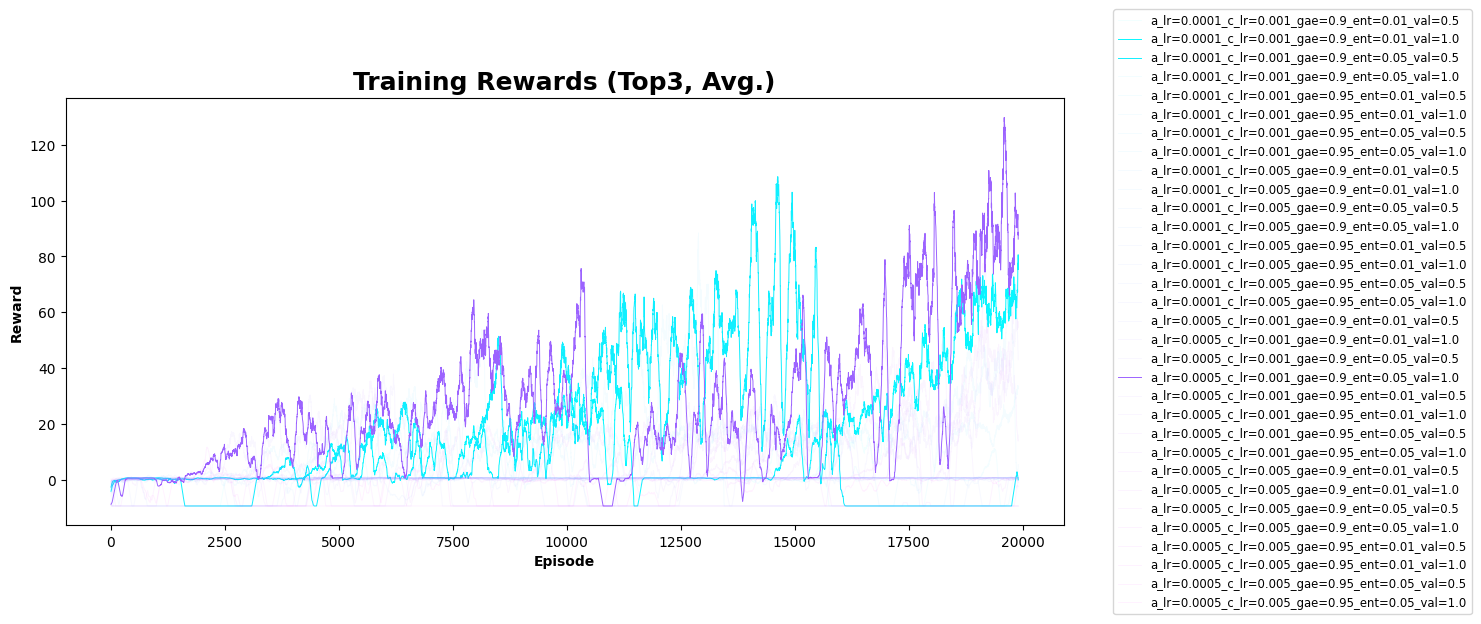

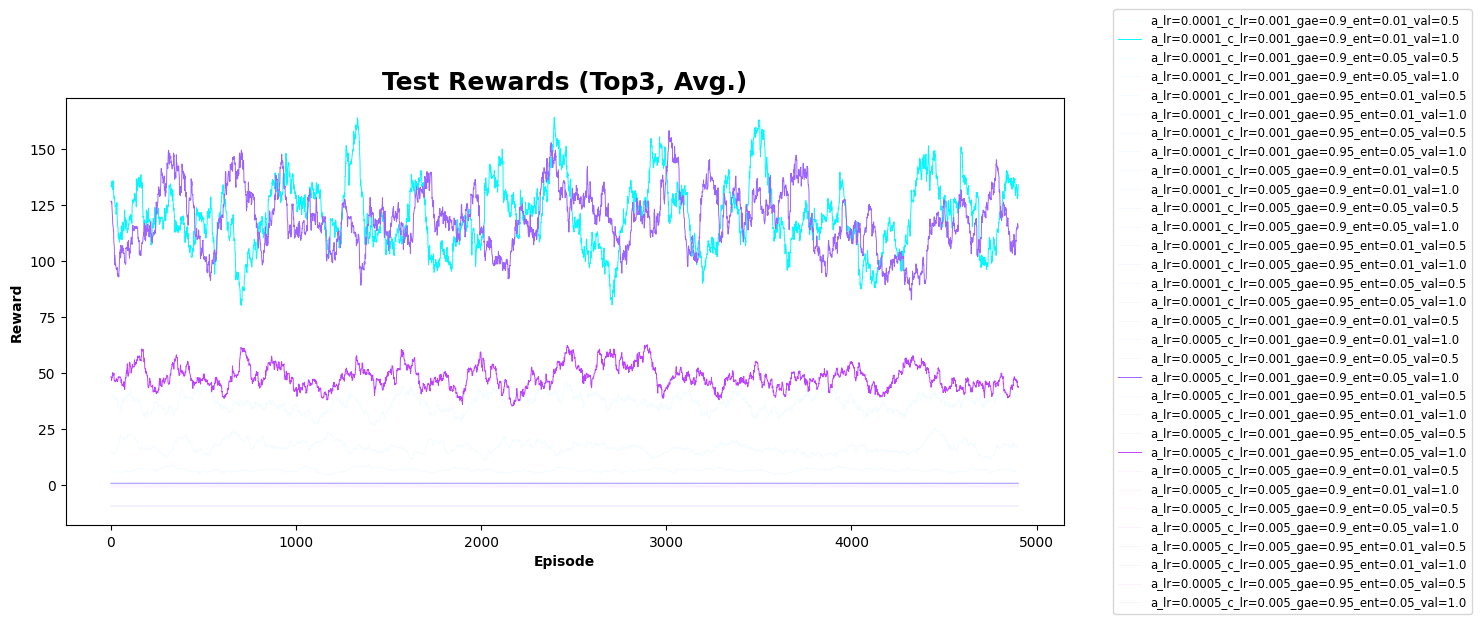

In [7]:

with open("../exp_data/eac_tr.pkl", "rb") as f:
    exp_res_DDQN_pp = pickle.load(f)
with open("../exp_data/eac_test.pkl", "rb") as f:
    test_res_DDQN_pp = pickle.load(f)

plot_rewards_with_opacity(exp_res_DDQN_pp, "Training Rewards (Top3, Avg.)", "Episode", "Reward","DDQN_tr.png")

# Plot for test_res (test rewards)
plot_rewards_with_opacity(test_res_DDQN_pp, "Test Rewards (Top3, Avg.)", "Episode", "Reward","DDQN_test.png")